In [40]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils
from keras.callbacks import TensorBoard
from keras import backend as K


import tensorflow as tf
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot

import numpy as np
import scipy.io
from PIL import Image
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import preprocessing
from IPython import display
import time

img_rows, img_cols, img_depth = 64, 64, 64

In [3]:
root_dir = 'dataset_withlabel/'
listing = os.listdir(root_dir)
maxval = 0.46
classes = {'none':0, 'left':1, 'right':2, 'click':3, 'wrist':4}

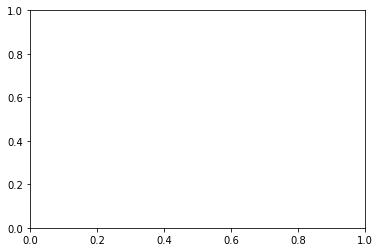

In [123]:
frames = []
labels = []
nongesture_count = 0
samples_per_class = np.zeros((5,1))

fig = plt.figure()
ax = fig.add_subplot(111)

for file in listing:
    file = root_dir + file
    data = scipy.io.loadmat(file)
    images = data['images']
    label = data['labels']
    num_frame = images.shape[0]
    
    rdm = np.zeros((64, 64))
    gt = 0
    nonzero_idx = np.nonzero(label)
    nonzero_idx_beg = np.min(nonzero_idx)
    nonzero_idx_end = np.max(nonzero_idx)
    gt = np.max(label)
    for i in range(nonzero_idx_beg, nonzero_idx_end):
        imgi = images[i].reshape(64, 64)
        rdm = np.maximum(rdm, imgi)
        
            
    background_rdm = np.zeros((64, 64))
    for i in range(nonzero_idx_end, num_frame):
        imgi = images[i].reshape(64, 64)
        rdm = np.maximum(rdm, imgi)
        rdm[:10,:] = np.min(rdm)
        frames.append(rdm)
        labels.append(gt)
        samples_per_class[gt] = samples_per_class[gt] + 1
        
        if gt == 4:
            frames.append(rdm)
            labels.append(gt)
            samples_per_class[gt] = samples_per_class[gt] + 1
            
            frames.append(rdm)
            labels.append(gt)
            samples_per_class[gt] = samples_per_class[gt] + 1
        
        if samples_per_class[0] < 30000:
            background_rdm = np.maximum(background_rdm, imgi)
            background_rdm[:10,:] = np.min(background_rdm)
            frames.append(background_rdm)
            labels.append(0)
            samples_per_class[0] = samples_per_class[0] + 1
#     ax.imshow(rdm)
#     title = str(i) + '/' + str(num_frame) + ', label:' + str(gt)
#     plt.title(title)
#     display.clear_output(wait=True)
#     display.display(fig)
#     time.sleep(0.1)

In [125]:
num_samples = len(frames)
# frames_arr =np.array(frames)

In [126]:
print(num_samples)

143547


In [127]:
gt = np.max(label)
print(gt)

2


In [128]:
X = np.array(frames)

In [129]:
labels = np.array(labels)

In [130]:
samples_per_class

array([[30000.],
       [27222.],
       [25347.],
       [37203.],
       [23775.]])

In [131]:
batch_size = 32
num_classes = 5
num_epoch = 20

In [132]:
y = np_utils.to_categorical(labels, num_classes)
X = X.reshape(num_samples, 64, 64, 1)

num_filters = [32, 32]
num_pool = [2, 2]
num_conv = [5, 3]

X = X.astype('float32')
X -= np.mean(X)
X /= np.max(X)

In [133]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

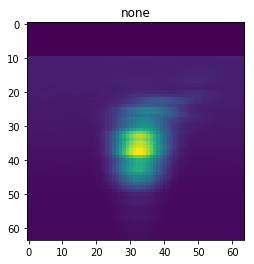

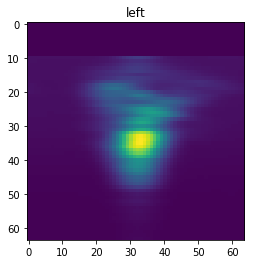

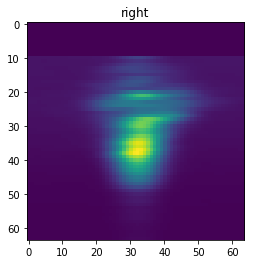

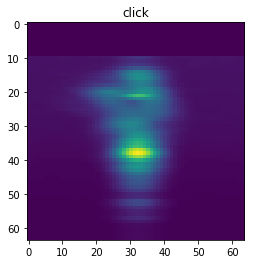

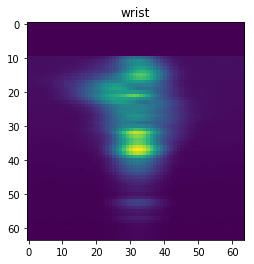

In [186]:
gesture_rdm = np.zeros((5, 64, 64))
for k in range(len(y_val)):
    a = X_val[k]
    b = a.reshape(64,64)
    gt_val = np.where(y_val[k]==1)[0][0]
    gesture_rdm[gt_val] = gesture_rdm[gt_val] + b
    
for i in range(0, 5):
    plt.figure()
    plt.imshow(gesture_rdm[i])
    plt.title(gestures[i])

In [135]:
K.clear_session()
model = Sequential()
print(num_filters[0], 'filters')
print('input shape', img_rows, 'rows', img_cols, 'cols')

model.add(Conv2D(16,
                 (5, 5),
                 input_shape=(img_rows, img_cols, 1),
                 activation='relu',
                 padding='SAME'))

model.add(MaxPooling2D(pool_size=4))
model.add(Dropout(0.5))

model.add(Conv2D(32,
                 (5, 5),
                 input_shape=(img_rows, img_cols, 1),
                 activation='relu',
                 padding='SAME'))

model.add(MaxPooling2D(pool_size=4))
model.add(Dropout(0.5))

# model.add(Conv2D(64,
#                  (3, 3),
#                  input_shape=(img_rows, img_cols, 1),
#                  activation='relu',
#                  padding='valid'))

# model.add(MaxPooling2D(pool_size=2, strides=2))
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, kernel_initializer='normal'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['mse', 'accuracy'])

model.summary()

32 filters
input shape 64 rows 64 cols
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5

In [136]:
hist = model.fit(X_train,
                 y_train,
                 validation_data=(X_val, y_val),
                 batch_size=batch_size,
                 epochs=num_epoch,
                 shuffle=True,
                 callbacks=[TensorBoard(log_dir='./tmp/log')]
)

Train on 114837 samples, validate on 28710 samples
Epoch 1/20
114837/114837 [==============================] - 27s 239us/step - loss: 0.9793 - mean_squared_error: 0.1017 - acc: 0.5955 - val_loss: 0.5311 - val_mean_squared_error: 0.0572 - val_acc: 0.8057
Epoch 2/20
114837/114837 [==============================] - 27s 236us/step - loss: 0.6436 - mean_squared_error: 0.0675 - acc: 0.7486 - val_loss: 0.3414 - val_mean_squared_error: 0.0365 - val_acc: 0.8924
Epoch 3/20
114837/114837 [==============================] - 27s 236us/step - loss: 0.4833 - mean_squared_error: 0.0508 - acc: 0.8153 - val_loss: 0.2101 - val_mean_squared_error: 0.0215 - val_acc: 0.9434
Epoch 4/20
114837/114837 [==============================] - 27s 236us/step - loss: 0.4163 - mean_squared_error: 0.0429 - acc: 0.8487 - val_loss: 0.1843 - val_mean_squared_error: 0.0187 - val_acc: 0.9504
Epoch 5/20
114837/114837 [==============================] - 27s 237us/step - loss: 0.3782 - mean_squared_error: 0.0383 - acc: 0.8657 - va

In [137]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

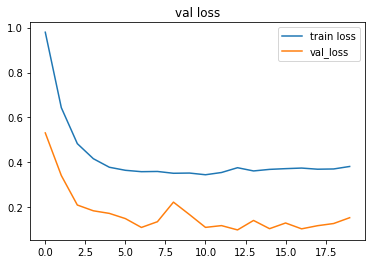

In [138]:
plt.plot(train_loss); plt.title('train loss')
plt.plot(val_loss); plt.title('val loss')
plt.legend(['train loss', 'val_loss'])

(0, 1)

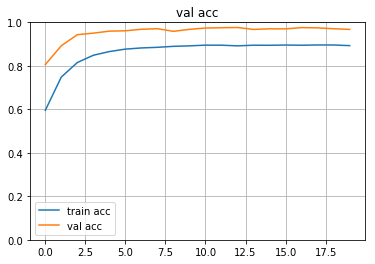

In [145]:
plt.plot(train_acc); plt.title('train acc')
plt.plot(val_acc); plt.title('val acc')
plt.legend(['train acc', 'val acc'])
plt.grid(True)
plt.ylim(0,1)

In [149]:
gestures = ['none', 'left', 'right', 'click', 'wrist']

Text(0.5,1,'wrist')

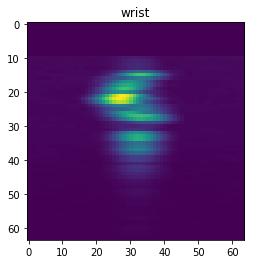

In [164]:
k = 5
a = X_val[k]
b = a.reshape(64,64)
plt.imshow(b)
gt_val = np.where(y_val[k]==1)[0][0]
plt.title(gestures[gt_val])

In [15]:
np.save('X.npy', X)
np.save('y.npy', y)